In [3]:
%matplotlib inline

import sqlite3
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from Utility import Database as db

## 21/10/05

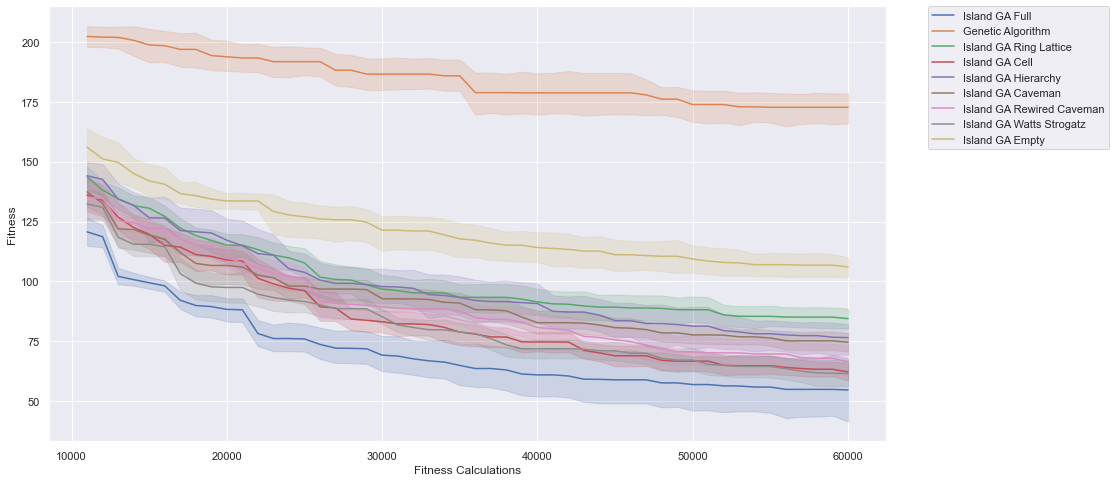

In [9]:
df = pd.DataFrame(columns=['Algorithm', 'Fitness Calculations', 'Epoch', 'Migration Rate', 'Fitness'])

configs = db.con.execute('''
    select * 
    from config 
    where 
        name="Rastrigin" and 
        population_size=640
''').fetchall()

for unnamed_tuple in configs:
    c = db.Config(*unnamed_tuple)
    if not 'G' in c.algorithm:
        continue

    results = db.con.execute(f'''
        select *
        from result
        where
            config_id={c.config_id}
        order by
            order_index
    ''').fetchall()

    for unnamed_result in results:
        r = db.Result(*unnamed_result)
        
        df = df.append({
            'Algorithm': c.algorithm,
            'Fitness Calculations': c.fitness_calculations,
            'Epoch': c.epochs_till_migration,
            'Migration Rate': c.migration_rate,
            'Fitness': r.fitness,
            
        }, ignore_index=True)


sns.set(rc = {'figure.figsize':(15,8)})
sns.set_theme(style="darkgrid")
sns.lineplot(data=df, x='Fitness Calculations', y='Fitness', hue='Algorithm')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## 21/09/29

In [98]:
def plot_epochs_migration_rate_vs_fitness(problem_name, population_size):
    algorithms = [
        'Island GA Ring Lattice',
        'Island GA Cell',
        'Island GA Hierarchy',
        'Island GA Caveman',
        'Island GA Rewired Caveman',
        'Island GA Watts Strogatz',
        'Island GA Full'
    ]
    
    fig = plt.figure(figsize=(15,18))
    subplots = fig.subplots((len(algorithms)//2)+1, 2, subplot_kw=dict(projection='3d'),)
    subplots = [item for sublist in subplots for item in sublist]
    
    for i, alg_name in enumerate(algorithms):
        df = pd.DataFrame(columns=['Epoch', 'Migration Rate', 'Fitness'])
        
        configs = db.con.execute(f'''
            select * 
            from config 
            where 
                name="{problem_name}" and 
                population_size={population_size} and
                algorithm="{alg_name}"
        ''').fetchall()

        for unnamed_tuple in configs:
            c = db.Config(*unnamed_tuple)

            results = db.con.execute(f'''
                select *
                from result
                where
                    config_id={c.config_id}
                order by
                    order_index
            ''').fetchall()

            for unnamed_result in results:
                r = db.Result(*unnamed_result)

                df = df.append({
                    'Epoch': c.epochs_till_migration,
                    'Migration Rate': c.migration_rate,
                    'Fitness': r.fitness
                }, ignore_index=True)
        
        ax = subplots[i]
        
        ax.set_xlabel('Epoch')
        ax.set_ylabel('MIgration Rate')
        ax.set_zlabel('Fitness')
        ax.set_title(alg_name)

        ax.plot_trisurf(df['Epoch'], df['Migration Rate'], df['Fitness'])
    plt.show()

Island GA Ring Lattice
Island GA Cell
Island GA Hierarchy
Island GA Caveman
Island GA Rewired Caveman
Island GA Watts Strogatz
Island GA Full


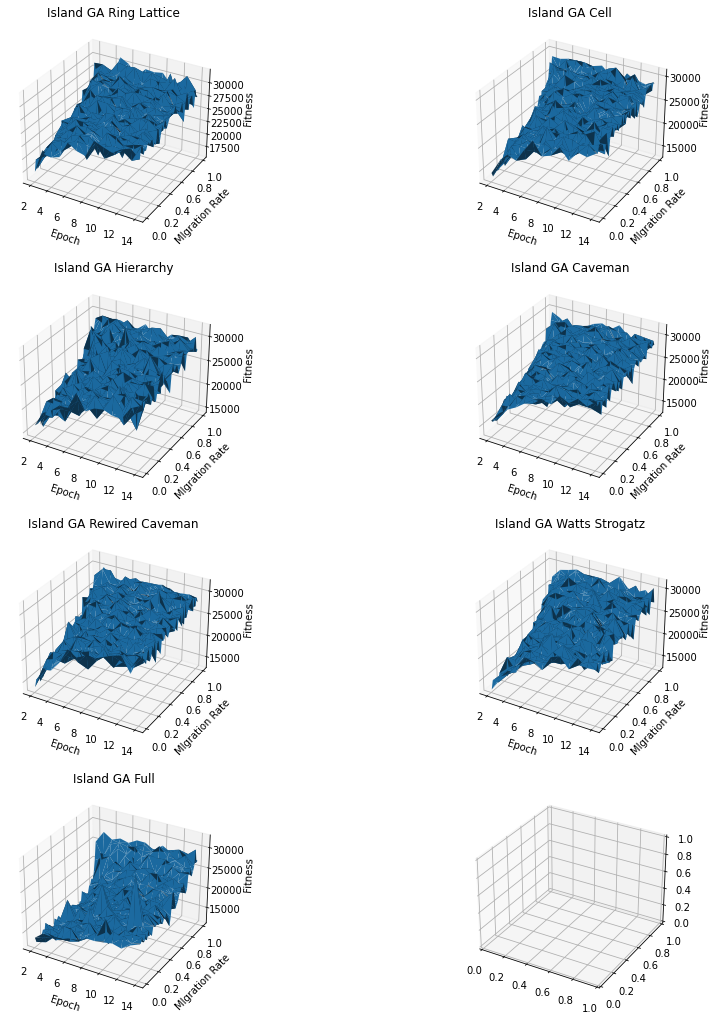

In [99]:
plot_epochs_migration_rate_vs_fitness('TSP', 320)